# Logistic Regression!

And some further practice with the metrics we use to evaluate classification problems.

In [1]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# From https://contrib.scikit-learn.org/categorical-encoding/
import category_encoders as ce

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix # New to version 0.22.2

In [2]:
df = pd.read_csv('titanic.csv', index_col = "PassengerId")

In [3]:
df.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

In [4]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
df.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [6]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Model-less Baseline

First of all, I want to see how well the model will do if it predicts the majority class. In other words, if the model only predicts that no one survives, what percentage of the time would it be right? We can then compare our accuracy scores from our models to see if we're improving upon this 'model-less' baseline score.

How do we do this? Find the number of passengers who didn't survive, divide by the total number of passengers.

In [7]:
num_passengers = len(df['Survived'])

In [8]:
num_passenger_didnotsurvive = len(df.loc[df['Survived'] == 0])

In [9]:
num_passenger_didnotsurvive / num_passengers
# Result: 61% is our initial baseline

0.6161616161616161

In [10]:
# Another way to do this - the mean of this column gives the percentage of
# passengers who DID survive because it's a 0/1 binary - find the inverse
1 - df['Survived'].mean()

0.6161616161616161

### Logistic Regression
To model this data, I'm going to first prepare the columns I want to use by following the strategy described [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [11]:
# I'll be using two types of columns - numeric and categorical
num_cols = ['Age', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked']

In [12]:
# Defining my target and my overall columns
target = 'Survived'
used_cols = num_cols + cat_cols

In [13]:
# Defining my X and y
X = df[used_cols]
y = df[target]

# And then doing a train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [14]:
# I'll be using separate strategies for the two types of columns
# For numeric columns, I'll be imputing nulls and scaling
num_imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

# For categorical columns, I'll be imputing nulls through the encoding
encoder = ce.TargetEncoder(cols=cat_cols, handle_missing="value")

In [15]:
# Creating the separate transformers for numeric and categorical columns
num_transformer = make_pipeline(num_imputer, scaler)
cat_transformer = make_pipeline(encoder)
# Defining my preprocessor, which combines the two transformers
preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_cols),
                  ('cat', cat_transformer, cat_cols)])

In [17]:
# Instantiating my model and pipeline
model = LogisticRegression()
pipe = make_pipeline(preprocessor, model)

In [18]:
# Now, fitting our pipeline and grabbing our training and testing predictions
pipe.fit(X_train, y_train)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

In [20]:
confusion_matrix(y_test, test_preds)

array([[133,  24],
       [ 32,  79]])

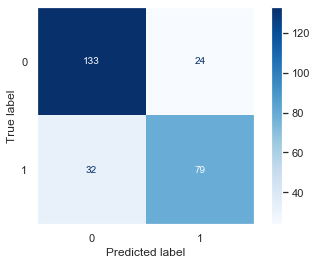

In [19]:
# Plotting the confusion matrix using SKLearn
plot_confusion_matrix(pipe, X_test, y_test,
                      cmap=plt.cm.Blues, # Changing the color scheme
                      values_format=".3g") # Formatting the numbers properly
plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

### Confusion Matrix Interpretation

Before we even look at the scores we get back from this model, let's look at the confusion matrix first.

![Confusion Matrix Interpreted, from https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html](confusionmatrixinterpretation.jpg)

Note! The above image has Positive first, then Negative - but SKLearn printed our confusion matrix with Negative first, then Positive.

Now - 

- Calculate the Precision score: TP / All Predicted Positives = 79 / (79+24) = .76699

- Calculate the Recall score, also known as the Sensitivity: TP / All Actual Positives = 79 / (79 + 32) = .71 

There's another score that's often referenced which balances precision and recall - it's called an [**F1 Score**](https://en.wikipedia.org/wiki/F1_score).

$$ \text{F1 Score} = 2 * \frac{ precision * recall}{precision + recall} $$

- Calculate the F1 score: 2 * (.76 * .71) / (.76 + .71) = .738

**Let's Discuss**: Why might we care more about precision than recall, or vice versa?

- 


----

Moving on - luckily SKLearn will of course calculate these scores for us. You can see all of their classification metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Let's look at our accuracy scores:

In [23]:
# Printing the metrics nicely
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, train_preds)}")
print(f"TEST: {accuracy_score(y_test, test_preds)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, train_preds)}")
print(f"TEST: {balanced_accuracy_score(y_test, test_preds)}")

Accuracy:
TRAIN: 0.7913322632423756
TEST: 0.7910447761194029

Balanced Accuracy:
TRAIN: 0.7692872603586889
TEST: 0.7794227348367475


### Evaluation:

So, how'd we do? Specifically, how'd we do compared to our model-less baseline?

- 


Why is the balanced accuracy lower than the default accuracy?

- 


### Next Steps

What can we potentially do to improve this model?

- Oversampling the minority or undersampling the majority to deal with class imbalance
- Balancing classes within Logistic Regression (set class_weight='balanced')
- Use a different encoder - like the Weight of Evidence encoder


## Further Practice

This time, with a wine quality dataset!

Found here: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009/data

Note: the target is where the quality, given in the original data, is greater than or equal to 7. The original 'quality' column has been removed and replaced by this new target, where a 1 can be interpreted to mean that the wine is of great quality.

In [19]:
wine_df = pd.read_csv("winequality-red-withtarget.csv")

In [20]:
wine_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  target  
0      9.4       0  
1      9.8       0  
2      9.8       0  
3      9.8       0  
4      9.4       0

In [21]:
wine_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol       target  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     0.135710  
std       0.154386     0.169507     1.065668     0.342587  
min       2.740000     0.330000     8.400000     0.000000  
25%       3.210000     0.550000     9.500000     0.000000  
50%       3.310000     0.620000    10.200000     0.000000  
75%       3.400000     0.730000    11.100000     0.000000  
max       4.010000     2.000000    14.900000     1.000000

In [22]:
wine_df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
target                  0
dtype: int64

Now it's your turn! Now what?